## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Data from other Detroit datasets could help inform feature creation and model selection. Other related datasets such as:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

Here, I am using.....
___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

## Step 1: Loading the data sets 

### 1). Look at data & Remove some attributions that may cause data leakage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
def load_data():
    df_train_raw = pd.read_csv('dataset/train.csv', encoding = "ISO-8859-1")
    df_test_raw = pd.read_csv('dataset/test.csv', encoding = "ISO-8859-1")

    ## Have to remove:
    # - collection_status - Flag for payments in collections
    # - compliance_detail - More information on why each ticket was marked compliant or non-compliant
    ## to prevent data leakage
    df_train_raw.drop(["collection_status", "compliance_detail", "balance_due", "payment_amount", "payment_amount", "payment_status"], axis=1, inplace=True)
    
    return df_train_raw, df_test_raw

In [5]:
df_train_raw, df_test_raw = load_data()

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
print(df_train_raw.shape)
df_train_raw.isnull().sum()

(250306, 29)


ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_date                  209193
g

In [7]:
print(df_test_raw.shape)
df_test_raw.isnull().sum()

(61001, 27)


ticket_id                         0
agency_name                       0
inspector_name                    0
violator_name                    28
violation_street_number           0
violation_street_name             0
violation_zip_code            36977
mailing_address_str_number     1014
mailing_address_str_name          3
city                              1
state                           331
zip_code                          3
non_us_str_code               61001
country                           0
ticket_issued_date                0
hearing_date                   2197
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
grafitti_status               58780
dtype: int64

### 2). Only look at properities that have a more complete dataset

In [8]:
print(df_train_raw.dtypes[df_train_raw.columns[df_train_raw.isnull().sum()/df_train_raw.shape[0] < 0.25]])
varUsed = list(df_train_raw.columns[df_train_raw.isnull().sum()/df_train_raw.shape[0] < 0.25])
print(varUsed)
print(len(varUsed))

ticket_id                       int64
agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
mailing_address_str_number    float64
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
dtype: object
['ticket_id', 'agency_name', 'inspector_name', 'violator_name', 'violation

In [9]:
print(df_test_raw.dtypes[df_test_raw.columns])

ticket_id                       int64
agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
violation_zip_code             object
mailing_address_str_number     object
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
non_us_str_code               float64
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
grafitti_sta

### 3). Explorary distributions on training and test datasets & Remove redundant properities 

In [10]:
def features(df, var, m):
    var = dict(df[var].value_counts())
    h = m if len(var) >= m else len(var)
    var_sorted = dict(sorted(var.items(), key=lambda x:x[1], reverse=True)[:h])
    
    names = list(var_sorted.keys())
    values = [v/df.shape[0] for v in var_sorted.values()]
    
    return names, values

In [11]:
varUsed = ['city', 'agency_name', 'violation_code', 'disposition', 
           'fine_amount', 'judgment_amount', 'late_fee', 'admin_fee', 'discount_amount'] 
#'clean_up_cost' always 0 
#'discount_amount' almost 0
#'violation_description' is represented by 'violation_code' already
#'admin_fee' and 'state_fee' have exact same ratio distribution, keep 'admin_fee' only

# 'ticket_issued_date', 'hearing_date'

0 city
['DETROIT', 'SOUTHFIELD', 'Detroit', 'detroit', 'DEARBORN', 'FARMINGTON HILLS'] [0.5470743809577078, 0.05367829776353743, 0.04193267440652641, 0.016711545068835744, 0.014530215016819413, 0.009304611155945124]
1 agency_name
['Buildings, Safety Engineering & Env Department', 'Department of Public Works', 'Health Department', 'Detroit Police Department', 'Neighborhood City Halls'] [0.6303644339328661, 0.29850263277748035, 0.03556846419981942, 0.03555647886986329, 7.990219970755794e-06]
2 violation_code
['9-1-36(a)', '9-1-81(a)', '22-2-88', '9-1-104', '22-2-88(b)', '22-2-45'] [0.39587944356108123, 0.17367142617436257, 0.11473955878005321, 0.0900337986304763, 0.02891660607416522, 0.02154962326112838]
3 disposition
['Responsible by Default', 'Not responsible by Dismissal', 'Not responsible by City Dismissal', 'Responsible by Admission', 'Responsible by Determination', 'Not responsible by Determination'] [0.5526835153771783, 0.1945418807379767, 0.13743577860698505, 0.054737001909662575

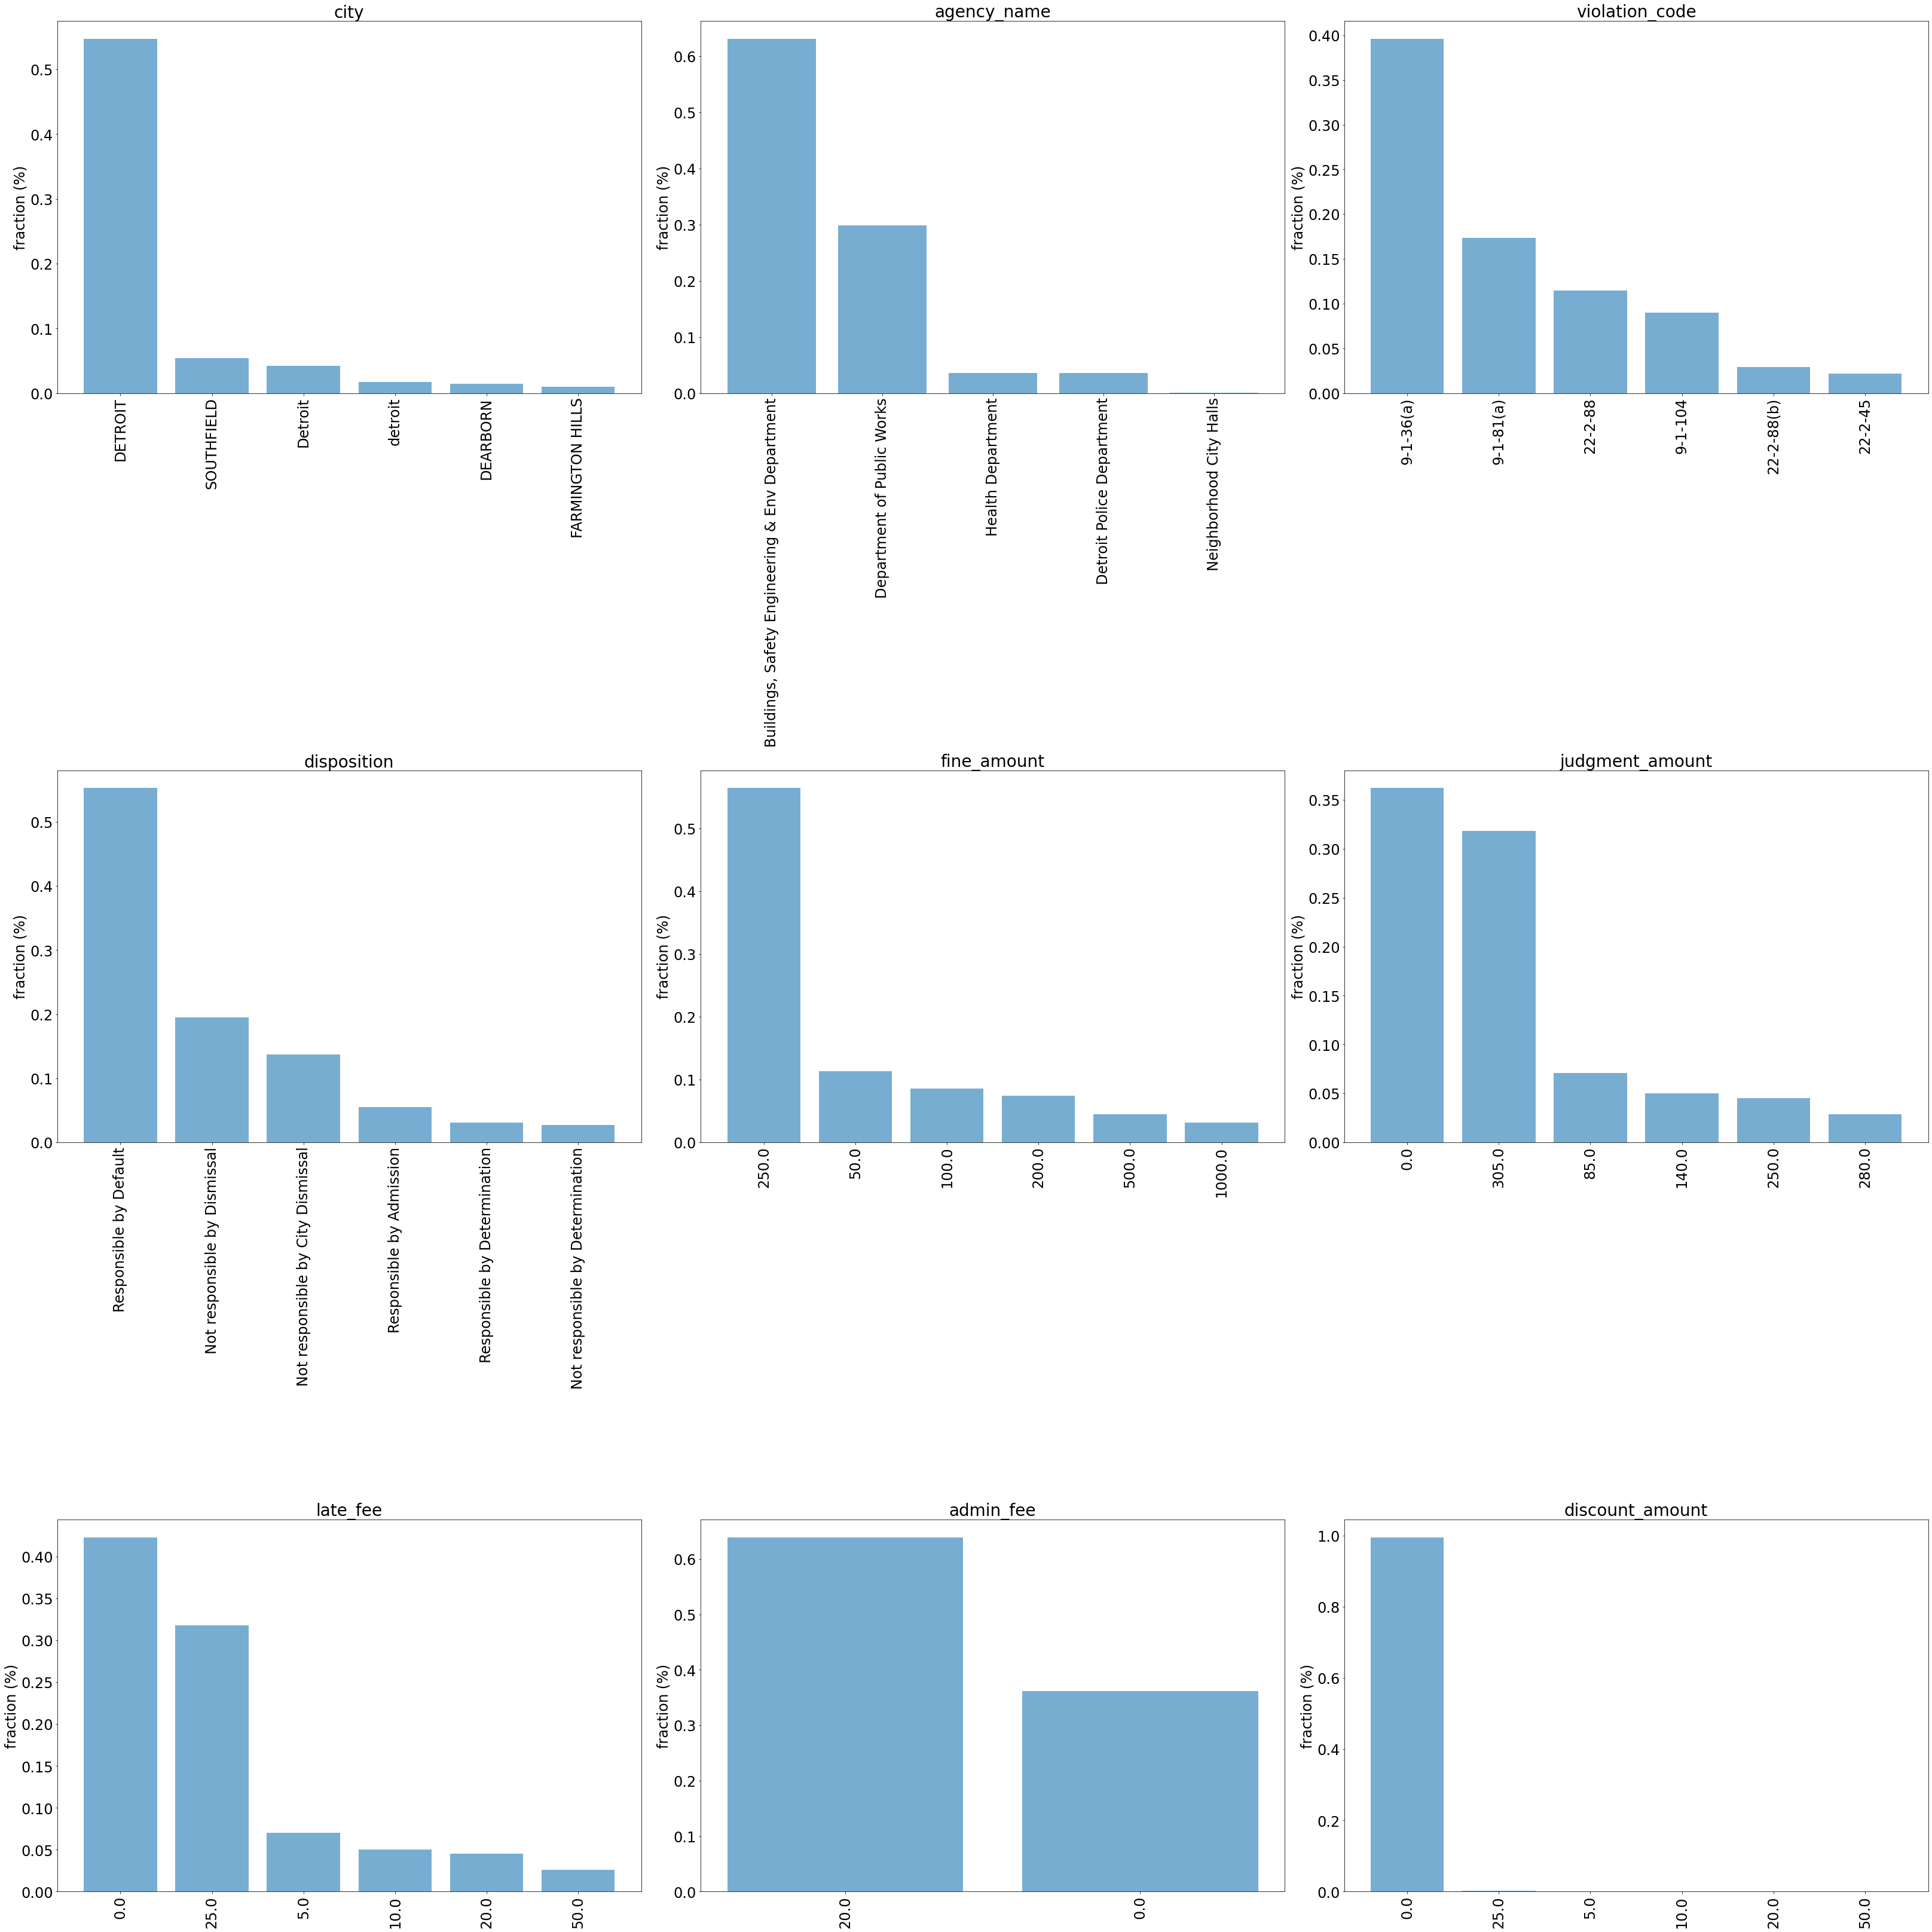

In [15]:
plt.subplots(3, 3, figsize=(45, 45))

for i, var in enumerate(varUsed):
    print(i, var)
    plt.subplot(3, 3, i+1)
    names, values = features(df_train_raw, var, 6)
    print(names, values)
    pop = plt.bar(range(len(values)), values, alpha=0.6)
    plt.xticks(range(len(values)), names, rotation='vertical', fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel('fraction (%)', fontsize=24)
    plt.title(var, fontsize=28)
plt.tight_layout()

0 city
['DETROIT', 'Detroit', 'SOUTHFIELD', 'DEARBORN', 'FARMINGTON HILLS', 'WEST BLOOMFIELD'] [0.43209127719217716, 0.0683267487418239, 0.04042556679398698, 0.02963885837937083, 0.01267192341109162, 0.011475221717676759]
1 agency_name
['Department of Public Works', 'Buildings, Safety Engineering & Env Department', 'Detroit Police Department'] [0.6677103654038459, 0.2759299027884789, 0.056359731807675284]
2 violation_code
['9-1-104', '22-2-88(b)', '9-1-36(a)', '22-2-45', '9-1-111', '9-1-110(a)'] [0.2665366141538663, 0.2573564367797249, 0.14185013360436713, 0.04662218652153243, 0.03681906853986, 0.03286831363420272]
3 disposition
['Responsible by Default', 'Responsible by Admission', 'Responsible by Determination', 'Responsible (Fine Waived) by Deter', 'Responsible - Compl/Adj by Default', 'Responsible - Compl/Adj by Determi'] [0.8459205586793659, 0.07350699168866084, 0.06760544909099851, 0.012803068802150784, 9.835904329437222e-05, 3.278634776479074e-05]
4 fine_amount
[50.0, 250.0, 100

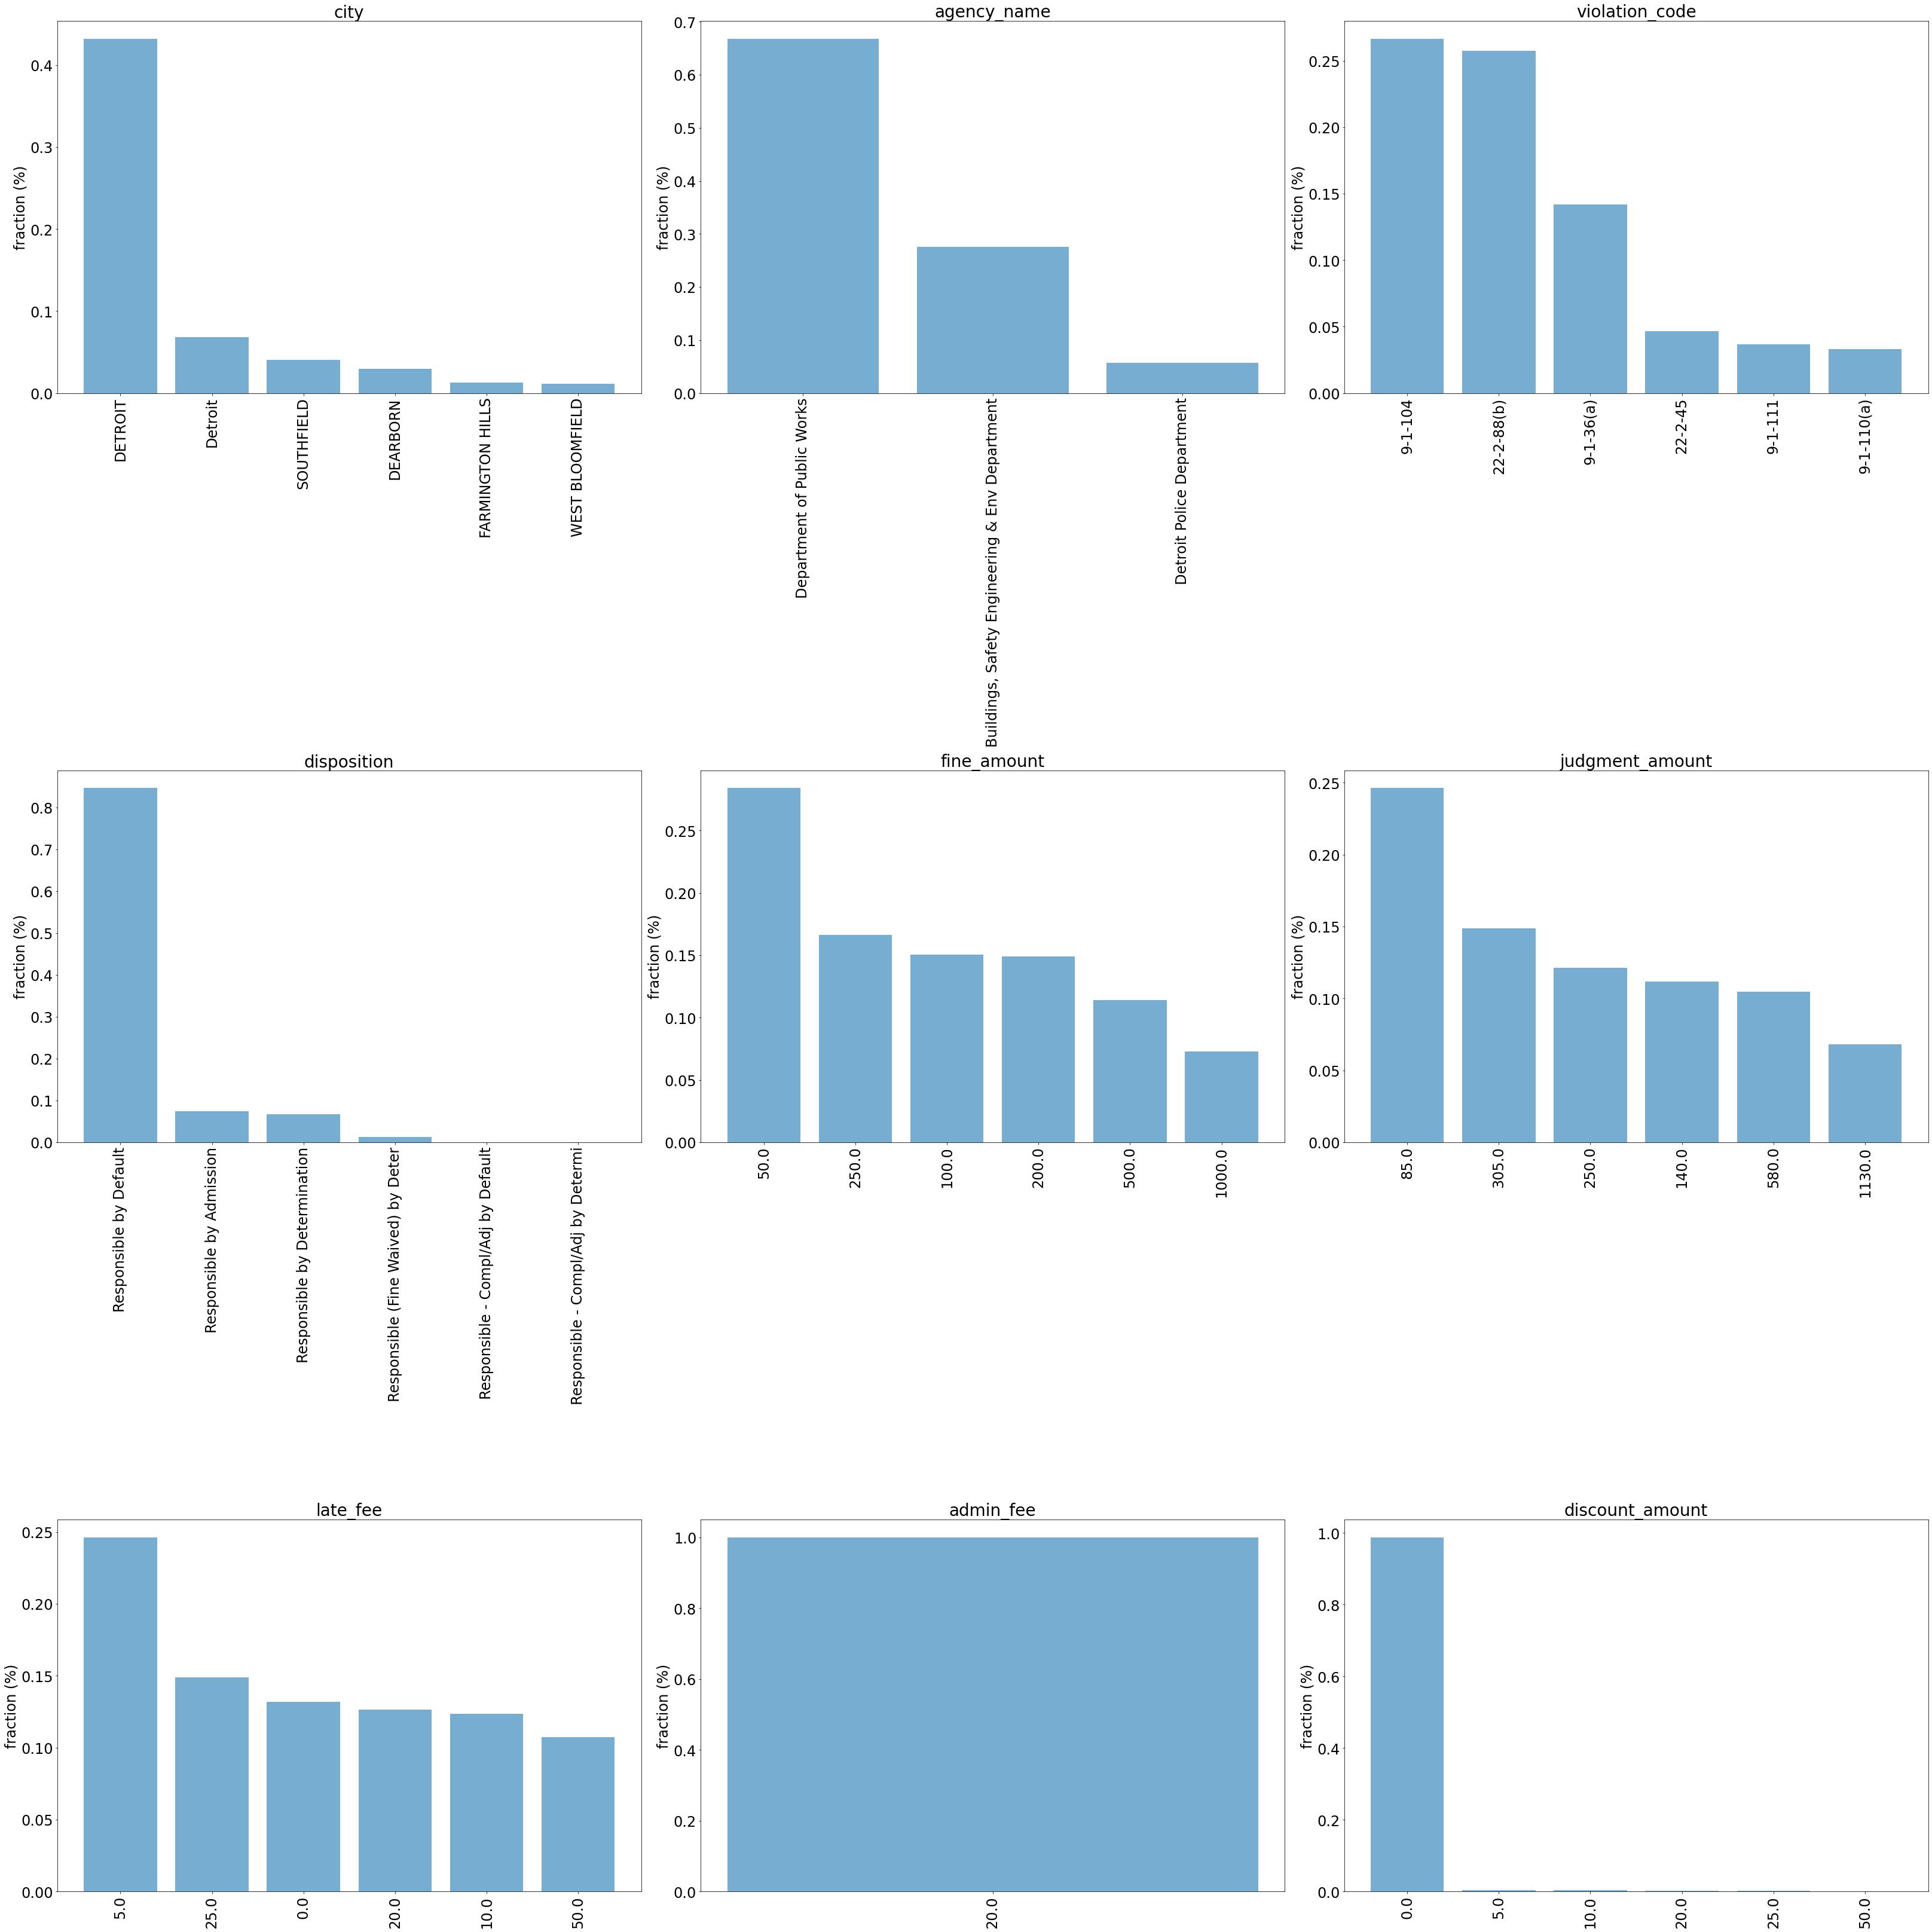

In [17]:
plt.subplots(3, 3, figsize=(45, 45))

for i, var in enumerate(varUsed):
    print(i, var)
    plt.subplot(3, 3, i+1)
    names, values = features(df_test_raw, var, 6)
    print(names, values)
    pop = plt.bar(range(len(values)), values, alpha=0.6)
    plt.xticks(range(len(values)), names, rotation='vertical', fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel('fraction (%)', fontsize=24)
    plt.title(var, fontsize=28)
plt.tight_layout()

In [23]:
def plot_Comp_train_test(plotVar, titleName, plotShowNumsorted=30, plotkind='bar', figsize=(18,3.2)):

    plt.subplots(1, 2, figsize=(18, 5))
    
    plt.subplot(1, 2, 1)
    yvalue = df_train_raw[plotVar].value_counts()
    (yvalue[:plotShowNumsorted]/df_train_raw.shape[0]).plot(kind="bar", alpha=0.6)
    plt.title(titleName+' (training set)')
    
    plt.subplot(1, 2, 2)
    yvalue = df_test_raw[plotVar].value_counts()
    (yvalue[:plotShowNumsorted]/df_test_raw.shape[0]).plot(kind="bar", alpha=0.6)
    plt.title(titleName+' (test set)')
    
    return plt

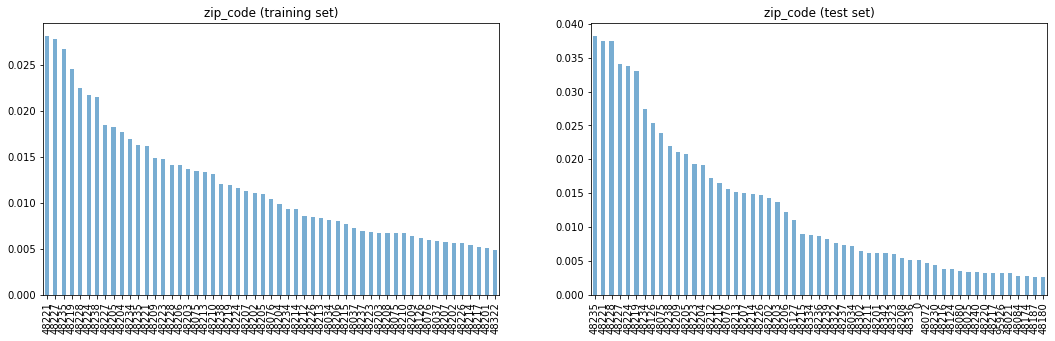

In [24]:
plot_Comp_train_test('zip_code', 'zip_code', plotShowNumsorted=55, figsize=(20,3.2));

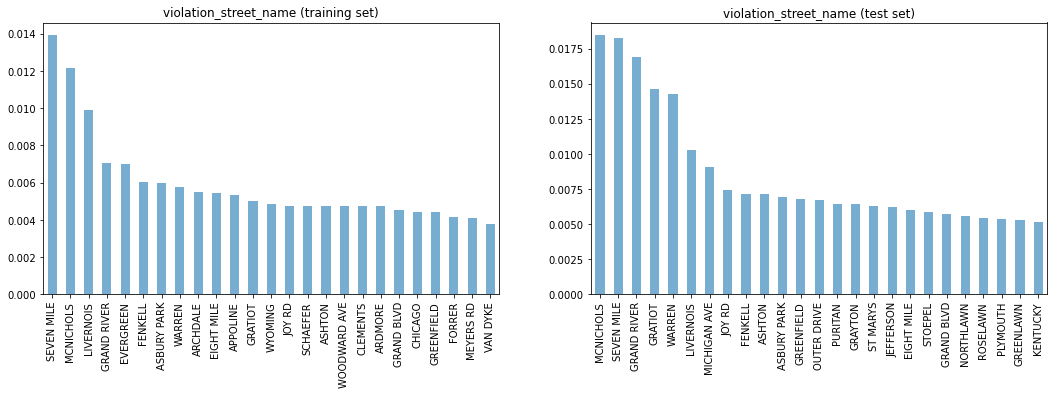

In [25]:
plot_Comp_train_test('violation_street_name', 'violation_street_name', plotShowNumsorted=25);

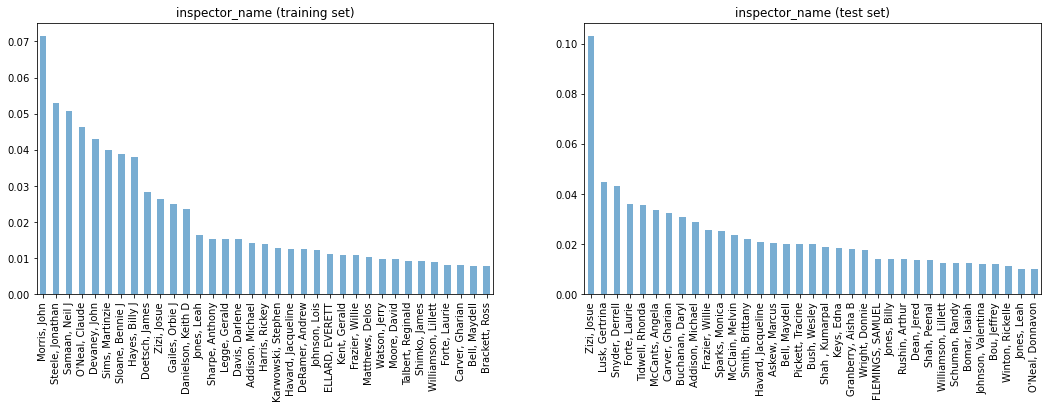

In [26]:
plot_Comp_train_test('inspector_name', 'inspector_name', plotShowNumsorted=35);

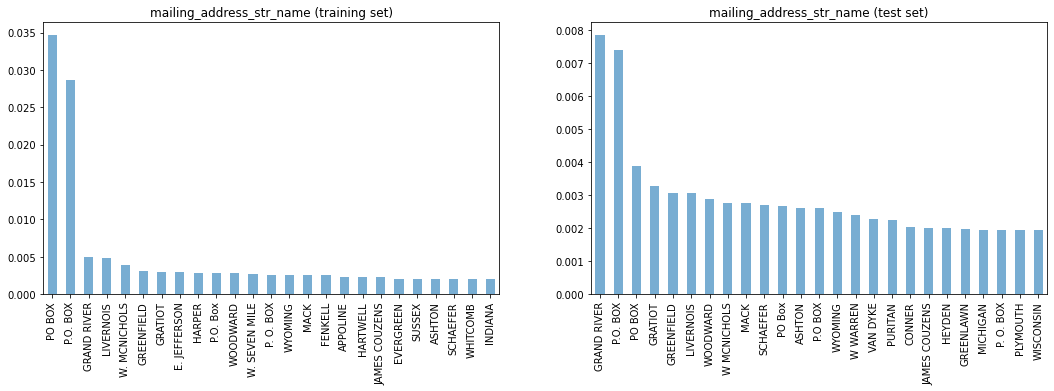

In [27]:
plot_Comp_train_test('mailing_address_str_name', 'mailing_address_str_name', plotShowNumsorted=25);

In [28]:
df_train_raw['discount_amount'].value_counts()

0.0      249126
25.0        605
5.0         167
10.0        155
20.0        135
50.0         43
3.0          19
30.0         17
100.0        16
350.0        15
250.0         6
40.0          1
13.0          1
Name: discount_amount, dtype: int64

In [29]:
df_test_raw['discount_amount'].value_counts()

0.0      60239
5.0        228
10.0       191
20.0       146
25.0        94
50.0        59
100.0       22
13.0         9
30.0         4
75.0         4
150.0        2
250.0        1
3.0          1
40.0         1
Name: discount_amount, dtype: int64

### 4). Parameter of Interest

In [30]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

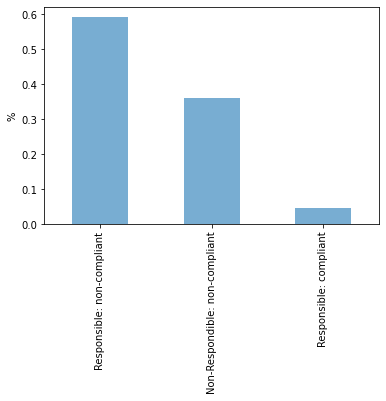

In [52]:
df_train['compliance'].fillna(-1, inplace=True)
yvalue = df_train['compliance'].value_counts()

fig, ax = plt.subplots()
(yvalue[:]/df_train.shape[0]).plot(kind="bar", alpha=0.6)

labels = ['Responsible: non-compliant', 'Non-Respondible: non-compliant', 'Responsible: compliant']
means = [59.2, 36.1, 4.6]

#for i, v in enumerate(means):
#    ax.text(v, i, str(v), color='blue', fontweight='bold')

ax.set_xticklabels(labels)
ax.set_ylabel('%');

#Null = non-compliant
# 0 = Responsible, non-compliant
# 1 = Responsible, compliant
# All tickets where the violators were found not responsible are not considered in test dataset.

In [37]:
df_train['compliance'].value_counts()/df_train.shape[0]

 0.0    0.592407
-1.0    0.361262
 1.0    0.046331
Name: compliance, dtype: float64

The training set is very imbalance, with a ration around 5% True. 

Some techniques used to further handling imbalanced data in classification problems are described here: 

https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f

with an scikit-learn libray https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html

(Discussion about this is not been included in this notebook.)

### 5). Convert text attributions into numerical values 

In [53]:
#fill_mostFreq = lambda x: x.fillna(x.value_counts().index[0])
#var in varUsed 
#for df_train[var].value_counts().index[0]

#if df_train.city.isnull().sum() > 0: 
#    df_train = df_train.apply(fill_mostFreq)
#if df_test.city.isnull().sum() > 0: 
#    df_test = df_test.apply(fill_mostFreq)

df_test['city'].fillna(df_train['city'].value_counts().index[0], inplace=True)

In [54]:
#0 city  
#train: ['DETROIT', 'SOUTHFIELD', 'Detroit', 'detroit', 'DEARBORN', 'FARMINGTON HILLS'] 
#[0.54707438095770777, 0.053678297763537428, 0.041932674406526413, 0.016711545068835744, 0.014530215016819413, 0.009304611155945124]
#test: ['DETROIT', 'Detroit', 'SOUTHFIELD', 'DEARBORN', 'FARMINGTON HILLS', 'WEST BLOOMFIELD'] 
#[0.43209127719217716, 0.068326748741823901, 0.040425566793986983, 0.02963885837937083, 0.012671923411091621, 0.011475221717676759]
def convt_city(convtStr):
    if convtStr in ['DETROIT', 'Detroit', 'detroit']:
        return 1
    elif convtStr in 'SOUTHFIELD':
        return 2
    elif convtStr in 'DEARBORN':
        return 3
    else:
        return 4
    
df_train['city'] = df_train['city'].apply(convt_city)
df_test['city'] = df_test['city'].apply(convt_city)
    
    
#1 agency_name
#['Buildings, Safety Engineering & Env Department', 'Department of Public Works', 'Health Department', 'Detroit Police Department', 'Neighborhood City Halls'] 
#[0.63036443393286612, 0.29850263277748035, 0.035568464199819419, 0.035556478869863288, 7.9902199707557944e-06]
#['Department of Public Works', 'Buildings, Safety Engineering & Env Department', 'Detroit Police Department'] 
#[0.66771036540384587, 0.2759299027884789, 0.056359731807675284]
def convt_agency_name(convtStr):
    if convtStr in 'Buildings, Safety Engineering & Env Department':
        return 1
    elif convtStr in 'Department of Public Works':
        return 2
    elif convtStr in 'Health Department':
        return 3
    elif convtStr in 'Detroit Police Department':
        return 4
    else:
        return 5
    
df_train['agency_name'] = df_train['agency_name'].apply(convt_agency_name)
df_test['agency_name'] = df_test['agency_name'].apply(convt_agency_name)


#2 violation_code
#['9-1-36(a)', '9-1-81(a)', '22-2-88', '9-1-104', '22-2-88(b)', '22-2-45'] 
#[0.39587944356108123, 0.17367142617436257, 0.11473955878005321, 0.090033798630476294, 0.02891660607416522, 0.02154962326112838]
#['9-1-104', '22-2-88(b)', '9-1-36(a)', '22-2-45', '9-1-111', '9-1-110(a)'] 
#[0.26653661415386631, 0.25735643677972492, 0.14185013360436713, 0.046622186521532431, 0.03681906853986, 0.032868313634202721]
def convt_violation_code(convtStr):
    if convtStr == '9-1-36(a)':
        return 1
    elif convtStr == '9-1-81(a)':
        return 2
    elif convtStr == '22-2-88':
        return 3
    elif convtStr == '9-1-104':
        return 4
    elif convtStr == '22-2-88(b)':
        return 5
    elif convtStr == '22-2-45':
        return 6
    else:
        return 7

df_train['violation_code'] = df_train['violation_code'].apply(convt_violation_code)
df_test['violation_code'] = df_test['violation_code'].apply(convt_violation_code)
    
    
#4 disposition
#['Responsible by Default', 'Not responsible by Dismissal', 'Not responsible by City Dismissal', 
#'Responsible by Admission', 'Responsible by Determination', 'Not responsible by Determination'] 
#[0.5526835153771783, 0.19454188073797671, 0.13743577860698505, 0.054737001909662575, 0.030538620728228646, 0.026523535192923862]
#['Responsible by Default', 'Responsible by Admission', 'Responsible by Determination', 'Responsible (Fine Waived) by Deter', 'Responsible - Compl/Adj by Default', 'Responsible - Compl/Adj by Determi'] 
#[0.84592055867936589, 0.073506991688660844, 0.067605449090998512, 0.012803068802150784, 9.8359043294372222e-05, 3.2786347764790741e-05]
def convt_disposition(convtStr):
    if convtStr in 'Responsible by Default':
        return 1
    elif 'Dismissal' in convtStr:
        return 2
    elif convtStr in 'Responsible by Admission':
        return 3
    elif convtStr in 'Responsible by Determination':
        return 4
    else:
        return 5

df_train['disposition'] = df_train['disposition'].apply(convt_disposition)
df_test['disposition'] = df_test['disposition'].apply(convt_disposition)
      
#'zip_code'
#'inspector_name'
#'violation_street_name'
#'mailing_address_str_name'

In [55]:
def convt_discount(convtNum):
    if convtNum > 0:
        return 1
    else:
        return 0
    
df_train['discount_amount'] = df_train['discount_amount'].apply(convt_discount)
df_test['discount_amount'] = df_test['discount_amount'].apply(convt_discount)

In [56]:
df_train['discount_amount'].value_counts()

0    249126
1      1180
Name: discount_amount, dtype: int64

In [57]:
df_test['discount_amount'].value_counts()

0    60239
1      762
Name: discount_amount, dtype: int64

### 6). Distributions for the target categories on the modelling variables

In [58]:
df_true = df_train[df_train.compliance == 1]
df_false = df_train[df_train.compliance != 1]
df_null = df_train[df_train.compliance == -1]

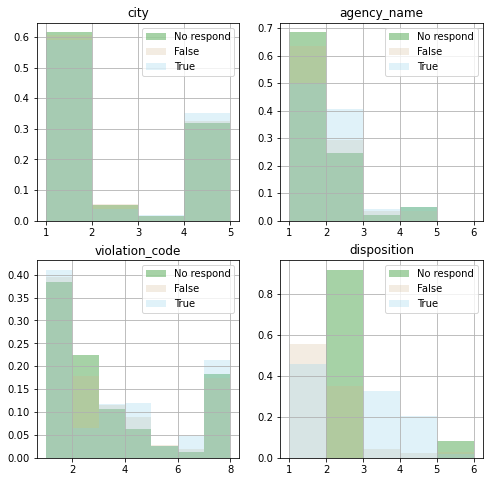

In [59]:
varPlot1 = ['city', 'agency_name', 'violation_code', 'disposition']

plt.subplots(2, 2, figsize=(8, 8))

for i, var in enumerate(varPlot1):
    plt.subplot(2, 2, i+1)
    nbins = df_train[var].nunique()
    df_null[var].hist(bins=nbins, range=[1, 1+nbins], alpha=0.35, density=True, color='green', label='No respond')
    df_false[var].hist(bins=nbins, range=[1, 1+nbins], alpha=0.25, density=True, color='tan', label='False')
    df_true[var].hist(bins=nbins, range=[1, 1+nbins], alpha=0.25, density=True, color='skyblue', label='True')
    plt.title(var)
    plt.legend()

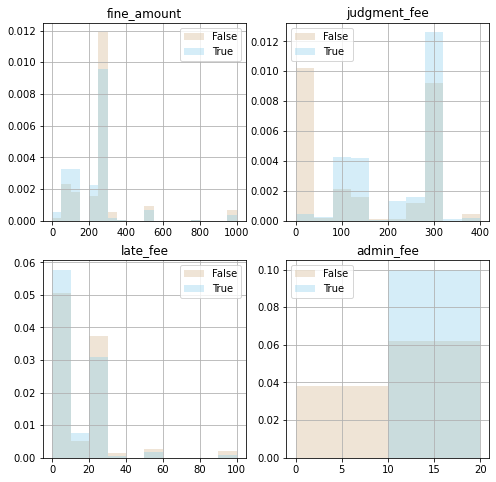

In [60]:
#varPlot2 = ['fine_amount', 'late_fee', 'judgment_amount', 'balance_due']

plt.subplots(2, 2, figsize=(8, 8))

plt.subplot(2, 2, 1)
df_false['fine_amount'].hist(bins=20, range=[0, 1000], alpha=0.35, density=True, color='tan', label='False')
df_true['fine_amount'].hist(bins=20, range=[0, 1000], alpha=0.35, density=True, color='skyblue', label='True')
plt.title('fine_amount')
plt.legend()

plt.subplot(2, 2, 2)
df_false['judgment_amount'].hist(bins=10, range=[0, 400], alpha=0.35, density=True, color='tan', label='False')
df_true['judgment_amount'].hist(bins=10, range=[0, 400], alpha=0.35, density=True, color='skyblue', label='True')
plt.title('judgment_fee')
plt.legend()

plt.subplot(2, 2, 3)
df_false['late_fee'].hist(bins=10, range=[0, 100], alpha=0.35, density=True, color='tan', label='False')
df_true['late_fee'].hist(bins=10, range=[0, 100], alpha=0.35, density=True, color='skyblue', label='True')
plt.title('late_fee')
plt.legend()

plt.subplot(2, 2, 4)
df_false['admin_fee'].hist(bins=2, range=[0, 20], alpha=0.35, density=True, color='tan', label='False')
df_true['admin_fee'].hist(bins=2, range=[0, 20], alpha=0.35, density=True, color='skyblue', label='True')
plt.title('admin_fee')
plt.legend();

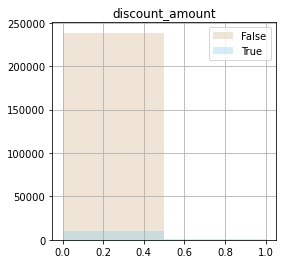

In [61]:
plt.subplots(1, 1, figsize=(4, 4))
df_false['discount_amount'].hist(bins=2, alpha=0.35, color='tan', label='False')
df_true['discount_amount'].hist(bins=2, alpha=0.35, color='skyblue', label='True')
plt.title('discount_amount')
plt.legend();

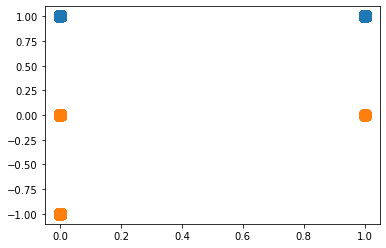

In [62]:
fig, ax = plt.subplots()
ax.plot(df_true['discount_amount'], df_true['compliance'], marker='o', linestyle='', ms=12)
ax.plot(df_false['discount_amount'], df_false['compliance'], marker='o', linestyle='', ms=12)
plt.show()

### make -1 as 0 in the categories

In [63]:
df_train['compliance'].replace({-1.0:0.0}, inplace=True)

In [64]:
varModel = ['ticket_id'] + varUsed 
df_model_test = df_test[varModel].copy()

varModel = varModel + ['compliance']
df_model = df_train[varModel].copy()

In [65]:
df_model.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        1
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [66]:
df_model.shape

(250306, 11)

In [67]:
df_model_test.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
dtype: int64

In [68]:
df_model_test.shape

(61001, 10)

In [69]:
df_model.dropna(axis=0, inplace=True)
df_model.shape

(250305, 11)

In [70]:
df_model.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [71]:
df_model.columns[1:-1]

Index(['city', 'agency_name', 'violation_code', 'disposition', 'fine_amount',
       'judgment_amount', 'late_fee', 'admin_fee', 'discount_amount'],
      dtype='object')

### 7). Show the correlation of selected properities

In [72]:
corr_pairs = df_train.corr().unstack()
corr_pairs_sorted = corr_pairs.sort_values(kind="quicksort")
corr_pairs_strong = corr_pairs_sorted[abs(corr_pairs_sorted) > 0.03]
print(corr_pairs_strong['compliance'])
#print(corr_pairs_strong)

fine_amount       -0.042418
late_fee          -0.032912
violation_code     0.033512
agency_name        0.049257
disposition        0.157762
state_fee          0.165763
admin_fee          0.165763
discount_amount    0.296428
compliance         1.000000
dtype: float64


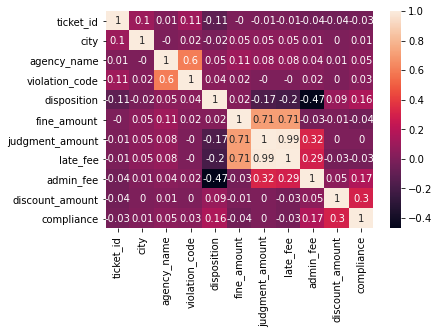

In [73]:
correlation = df_model.corr().round(2)
sns.heatmap(data=correlation, annot=True);

## Step: Dump data ready for training

In [147]:
df_model.to_csv(r'dataset/cleaned_train.csv', index=False)

## Step: Apply modelling algorithms

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [75]:
X = df_model[df_model.columns[1:-1]]
y = df_model['compliance']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=0, test_size=0.05)

### Feature scaling

In [76]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_dev_norm = scaler.transform(X_dev)

### 1). Logistic Regression

[[11896     2]
 [  531    87]]


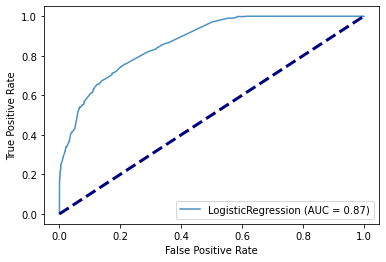

Cross-validation (AUC) [0.84430571 0.89260607 0.86452483 0.83938596 0.86987451] , mean = 0.862


In [142]:
clf_LogReg = LogisticRegression().fit(X_train_norm, y_train)
y_pred = clf_LogReg.predict(X_dev_norm)

confusion = confusion_matrix(y_dev, y_pred)
print(confusion)

ax = plt.gca()
roc_LogReg = plot_roc_curve(clf_LogReg, X_dev_norm, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_LogReg, X_dev_norm, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_LogReg, X_dev_norm, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [143]:
y_pred = clf_LogReg.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 4.94%


### 2). Support Vector Machine 

gamma = 0.01  accuracy = 0.96   AUC = 0.75
gamma = 0.10  accuracy = 0.96   AUC = 0.72
gamma = 1.00  accuracy = 0.96   AUC = 0.69
gamma = 10.00  accuracy = 0.96   AUC = 0.62


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


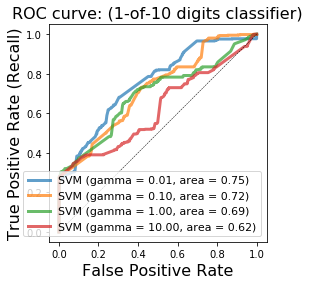

In [59]:
for g in [0.01, 0.1, 1.0, 10]:
    
    svm = SVC(gamma=g).fit(X_train, y_train)
    y_score_svm = svm.decision_function(X_dev)
    fpr_svm, tpr_svm, _ = roc_curve(y_dev, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = svm.score(X_dev, y_dev)
    print("gamma = {:.2f}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy_svm, 
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7, 
             label='SVM (gamma = {:0.2f}, area = {:0.2f})'.format(g, roc_auc_svm))

    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: (1-of-10 digits classifier)', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

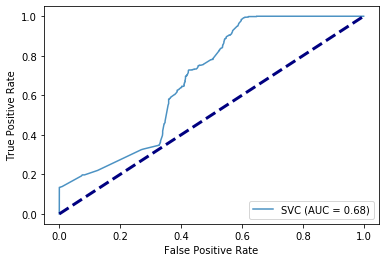

Cross-validation (AUC) [0.67417152 0.72751418 0.75628544 0.65892927 0.65907843] , mean = 0.7


In [26]:
clf_svm = SVC().fit(X_train, y_train)

ax = plt.gca()
roc_svm = plot_roc_curve(clf_svm, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_svm, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_svm, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [ ]:
grid_values = {'kernel':['poly','rbf','sigmoid'], 
               'C':[0.8, 1.0, 1.2]} 
               #'class_weight':['balanced',None]
               #'gamma': [0.001, 0.005, 0.01, 0.02, 0.05], 

clf_svm = SVC(gamma=0.01).fit(X_train, y_train)

grid_clf_auc = GridSearchCV(clf_svm, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

In [ ]:
grid_values = {'gamma': [0.005, 0.01, 0.02]}
                #'kernel':['poly','rbf','sigmoid'], 
                #'C':[0.8, 1.0, 1.2], 
                #'class_weight':['balanced',None]}
                #'gamma': [0.001, 0.005, 0.01, 0.02, 0.05]

clf_svm = SVC().fit(X_train, y_train)

grid_clf_auc = GridSearchCV(clf_svm, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

### 3). Naive Bayers Classifier

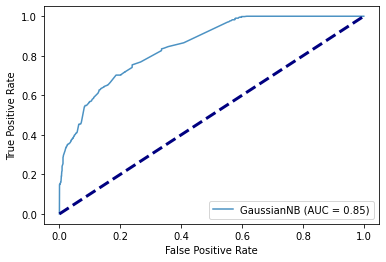

Cross-validation (AUC) [0.85295304 0.8803597  0.83763408 0.82820276 0.84445721] , mean = 0.849


In [83]:
clf_NBayers = GaussianNB().fit(X_train, y_train)

ax = plt.gca()
roc_NBayers = plot_roc_curve(clf_NBayers, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_NBayers, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_NBayers, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [140]:
y_pred = clf_NBayers.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 45.16%


### 4). Random Forest

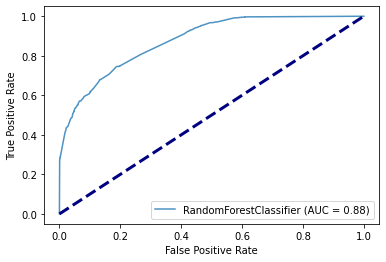

Cross-validation (AUC) [0.84097655 0.87296065 0.86166564 0.81906704 0.84136395] , mean = 0.847


In [78]:
clf_RandForest = RandomForestClassifier(random_state=0).fit(X_train, y_train)

ax = plt.gca()
roc_RandForest = plot_roc_curve(clf_RandForest, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_RandForest, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_RandForest, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [139]:
y_pred = clf_RandForest.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 96.33%


In [ ]:
grid_values = {'n_estimators':[10, 50, 100, 500], 
               'max_features':[], 
               'max_depth':[]}

grid_clf_auc = GridSearchCV(clf_RandForest, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
#y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

#ax = plt.gca()
#roc_RandForest = plot_roc_curve(clf_RandForest, X_dev, y_dev, ax=ax, alpha=0.8)
#plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
#plt.show()

#print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

### 5). Decision Tree

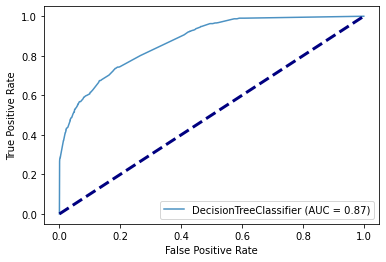

Cross-validation (AUC) [0.79939008 0.858774   0.83804741 0.8053855  0.80852113] , mean = 0.822


In [79]:
clf_DecisTree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

ax = plt.gca()
roc_DecisTree = plot_roc_curve(clf_DecisTree, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_DecisTree, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_DecisTree, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [138]:
y_pred = clf_DecisTree.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 96.32%


In [80]:
dic = {key: value for key, value in zip(X_train.columns, clf_DecisTree.feature_importances_)}
dic_sorted = sorted(dic.items(), key=lambda x: x[1], reverse=True)
features_most5 = [key for key, _ in dic_sorted[:5]]

print(features_most5)

['disposition', 'discount_amount', 'admin_fee', 'late_fee', 'judgment_amount']


#### Gradient-boosted decision trees

In [81]:
grid_values = {'n_estimators':[50, 100, 500, 600, 700, 1000], 
               'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5], 
               'max_depth':[2, 3, 4]}

grid_clf_auc = GridSearchCV(clf_BDT, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)

print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

NameError: name 'clf_BDT' is not defined

In [42]:
grid_values = {'n_estimators':[700,750,800], 
               'learning_rate':[0.04,0.05,0.06]}

clf_BDT = GradientBoostingClassifier().fit(X_train, y_train)
grid_clf_auc = GridSearchCV(clf_BDT, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)

print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Grid best parameter (max. AUC):  {'learning_rate': 0.05, 'n_estimators': 700}
Grid best score (AUC):  0.8804828645253456


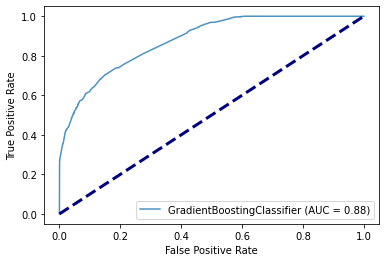

Cross-validation (AUC) [0.86640519 0.89233962 0.88003348 0.84364703 0.86550496] , mean = 0.87


In [82]:
clf_BDT = GradientBoostingClassifier(learning_rate=0.05, n_estimators=700).fit(X_train, y_train)

ax = plt.gca()
roc_BDT = plot_roc_curve(clf_BDT, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_BDT, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_BDT, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [136]:
y_pred = clf_BDT.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 96.32%


### 6). Stochastic Gradient Descent

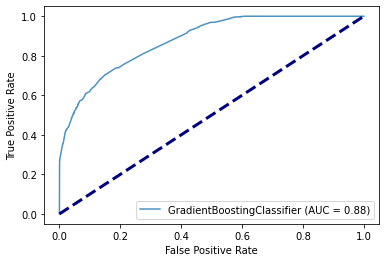

Cross-validation (AUC) [0.79849044 0.87337398 0.78626085 0.80560923 0.75094747] , mean = 0.796


In [134]:
clf_SGD = SGDClassifier(loss='hinge', penalty='l2', max_iter=100).fit(X_train_norm, y_train)

ax = plt.gca()
roc_SGD = plot_roc_curve(clf_BDT, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_SGD, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_SGD, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [135]:
y_pred = clf_SGD.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 4.94%


### 7). Kernel Approximation

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


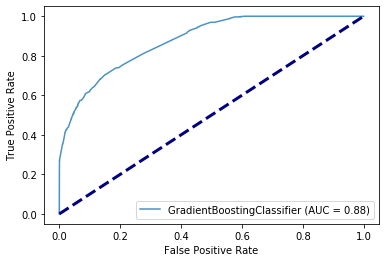

Cross-validation (AUC) [0.86473807 0.89233279 0.88004372 0.84364703 0.86550496] , mean = 0.869


In [23]:
rbf_feature = RBFSampler(gamma=1, random_state=0)
X_features = rbf_feature.fit_transform(X_train)

ax = plt.gca()
roc_BDT = plot_roc_curve(clf_BDT, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_BDT, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_BDT, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

### 8). XGBoost

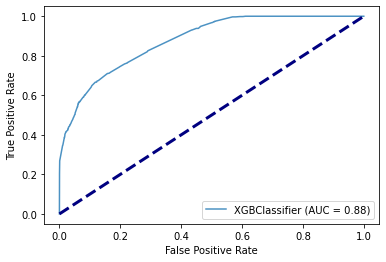

Cross-validation (AUC) [0.8669321  0.9022631  0.88137767 0.83960291 0.87242878] , mean = 0.873


In [105]:
clf_XGB = XGBClassifier().fit(X_train, y_train)

ax = plt.gca()
roc_XGB = plot_roc_curve(clf_XGB, X_dev, y_dev, ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

print('Cross-validation (AUC)', cross_val_score(clf_XGB, X_dev, y_dev, cv=5, scoring = 'roc_auc'), 
      ', mean =', round(cross_val_score(clf_XGB, X_dev, y_dev, cv=5, scoring = 'roc_auc').mean(), 3))

In [132]:
y_pred = clf_XGB.predict(X_dev)

acc = accuracy_score(y_dev, y_pred)
print("Accuracy: %.2f%%" %(acc *100.0))

Accuracy: 96.32%


In [ ]:
def build_model():
    pipeline = Pipeline([
        
    ])

In [ ]:
def result_display(cv, y_test, y_pred):
    

In [ ]:
def main(X_train, X_test, y_train, y_test):
    
    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    result_display(model, y_test, y_pred)

## Step: Select modelling algorithm & Optimization the parameters

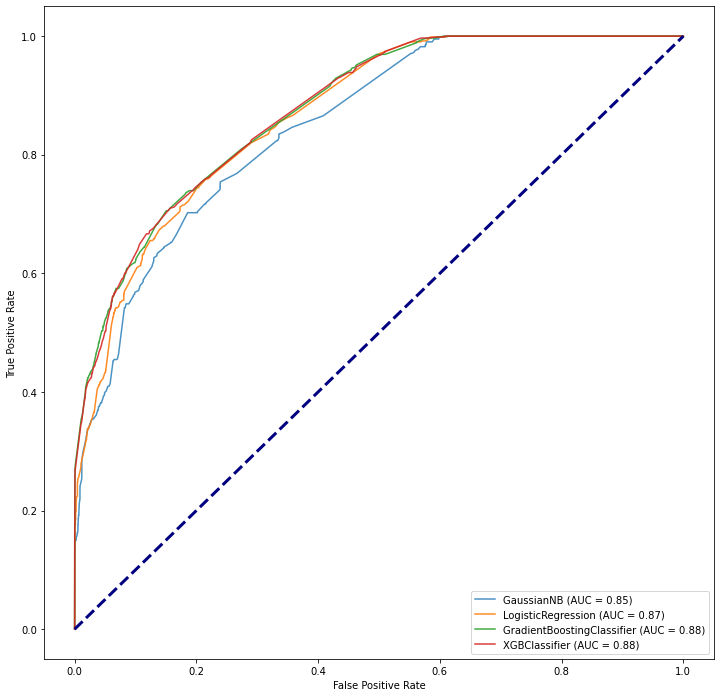

In [120]:
plt.subplots(1, 1, figsize=(12, 12))
ax = plt.gca()
roc_NBayers.plot(ax=ax, alpha=0.8)
roc_LogReg.plot(ax=ax, alpha=0.9)
#roc_svm.plot(ax=ax, alpha=0.8)
#roc_RandForest.plot(ax=ax, alpha=0.8)
#roc_DecisTree.plot(ax=ax, alpha=0.8)
roc_BDT.plot(ax=ax, alpha=0.9)
roc_XGB.plot(ax=ax, alpha=0.9)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

Confusion matrix:
 [[11891     7]
 [  453   165]]


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


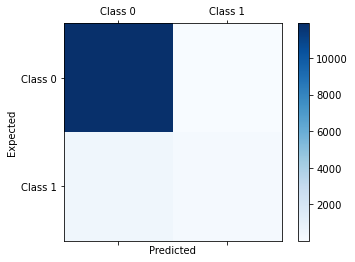

In [128]:
conf_mat = confusion_matrix(y_true=y_dev, y_pred=y_pred)
print("Confusion matrix:\n", conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show();